In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# MolDQN

>Implementing MolDQN with MRL

## MolDQN

[MolDQN](https://www.nature.com/articles/s41598-019-47148-x) is a actor/critic based RL approach to compound generation. The MolDQN paradigm differs from MRL's generative model approach. For this reason, MolDQN makes for an interesting example of integrating new or different modeling apporaches into MRL.

### MRL Approach

MRL focuses mainly on generative models. These are models that produce chemical structures through some sampling process. Generative models give us a probability associated with each sample. This allows us to run an optimization procedure where we tell the generative model to increase the probability of high scoring compounds. The score for each compound is given by some model or function outside the generative model.

### The MolDQN Approach

MolDQN uses an actor/critic approach. The actor/critic models are given some molecular state and predict a scalar score value from that state. This means there are no generative models involved. So how do we get new molecule states? MolDQN uses a heuristics based approach to generating new compounds. This works as follows:
1. Start with some initial state (ie `CCC`)
2. Define a list of allowed atom types and bond types (ie `['C', 'O', 'N']`, `['single', 'double', 'triple']`)
3. Create all variants of the initial state with 1 atom added or 1 bond added (`CCCO`, `C=CC`, `CC(C)=N`, ...)
4. Use the model to score each possible next state
5. Select the state with the highest predicted score

This process lets us build up a set of `(state, next_state)` sample pairs. Then during optimization, we train the model to predict the value of `state` plus a portion of the value of `next_state`. Including a portion of future rewards in the prediction is an important part of MolDQN. We could forego the RL aspect of this entirely and use just the sampling procedure in a beam-search sort of way where we calculate the highest value next state and simply choose that. The flaw with this approach is it can lead to getting stuck in local optima. With RL, we hope the model can learn that choosing a state that has a lower value on the next immediate step can actually be advantgeous as it can lead to an overall higher reward in say 3 steps.

### Integrating MolDQN

To integrate the MolDQN approch into MRL, we need to design the following:
1. A `Base_Dataset` variant for MolDQN
2. A `Agent` variant for MolDQN
3. A `Sampler` variant for MolDQN


## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## MolDQN Dataset

We need to build a variant of `Base_Dataset` to work with MolDQN. This means we need to implement the following methods:
- `__len__`
- `__getitem__`
- `new`
- `split_on_idxs`

We also need a collate function.

First we need to decide what our samples are going to look like. To be comptible with MRL, samples need to be hashable.

MolDQN requires three pieces of information to make a prediction:
- Initial state
- Current step
- Possible next states

The initial state will be a SMILES string. The dataloader will convert the SMILES string into a fingerprint to be sent to the model.

The current step will be an integer value. The use of this value is discussed more later. In short, MolDQN alters the score of a state based on how many steps the model has been running to ty encourage the model to pursue longer rollout paths. This value will be concatenated to the initial state fingerprint.

The possible next states will be a tuple of SMILES strings. These will be converted into a batch of fingerprints.

With this definition, a sample might look like:

`('CCC', 4, ('CCCC', 'CCC=N', 'CCCO'))`

Which would be converted to 

`[FP('CCC'),4], [[FP('CCCC'), 3], [FP('CCC=N'), 3], [FP('CCCO'), 3]]`

In [ ]:
class DQNDataset(Base_Dataset):
    def __init__(self, samples, fp_function, collate_function):
        super().__init__(collate_function)
        
        self.samples = samples
        self.fp_function = fp_function
        
    def __len__(self):
        return len(self.samples)
    
    def get_state_fps(self, state, steps_left):
        fp = fp_to_array(self.fp_function(state))
        fp = np.append(fp, steps_left)
        return torch.tensor(fp).float()
    
    def get_next_state_fps(self, next_states, steps_left):
        next_fps = [fp_to_array(self.fp_function(i)) for i in next_states]
        next_fps = np.stack([np.append(i, steps_left-1) for i in next_fps])
        return torch.tensor(next_fps).float()
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        smile, steps_left, next_states = sample
        fp = self.get_state_fps(smile, steps_left)
        next_fps = self.get_next_state_fps(next_states, steps_left)
        
        return fp, next_fps
    
    def new(self, samples):
        return self.__class__(samples, self.fp_function, self.collate_function)
    
    def split_on_idxs(self, train_idxs, valid_idxs):
        
        train_ds = self.new([self.samples[i] for i in train_idxs])
        valid_ds = self.new([self.samples[i] for i in valid_idxs])
        return (train_ds, valid_ds)
        
    
def moldqn_collate(batch):
    fps = torch.stack([i[0] for i in batch])
    
    y_size = max([i[1].shape[0] for i in batch])
    y_block = torch.zeros((len(batch), y_size, fps.shape[-1]))-1
    
    nfps = [i[1] for i in batch]
    for i, nfp in enumerate(nfps):
        num_fps = nfp.shape[0]
        y_block[i, :num_fps] = nfp

    return fps, y_block

In [ ]:
ds = DQNDataset([('C', 4, ('CCC'))], ECFP6, moldqn_collate)

## MolDQN Agent

Since our data is tensorized into fingerprint vectors, our model will be a MLP-type model. We now need to build an `Agent` to use this model.

MolDQN uses a double Q learning approach. This fits with the `BaselineAgent` framework of having a main model and a baseline model.

We build a new `BaselineAgent` with the following methods implemented:
- `setup`: define terms to log for MolDQN
- `before_compute_reward`: correctly tensorize samples
- `reward_modification`: apply reward scaling (see below)
- `compute_loss`: compute MolDQN loss (see below)

### Reward Modification

MolDQN modifies rewards based on what step the reward was generated. If we rollout samples over 40 steps, we want to bias the model towards long sample paths rather than ones that terminate early. This is accomplished by scaling the reward by `reward_modified = reward * scaling_factor ** steps_left`.

The MolDQN authors call this scaling factor a "discount factor". This is extremely annoying because "discount factor" is already a standard concept in RL. The MolDQN authors create a completely different concept then give it the same name, presumably just to confuse you.

Standard RL discounting takes the form `reward_discounted[i] = reward[i] + discount_factor*reward[i+1]`, where the discount factor adds a small amount of future reward to the current reward. MolDQN "discounting" is purely based on the number of steps left, and has the effect of reducing the current reward rather than adding to it.

We implement this as a reward modification. This means we can see the true undiscounted rewards as well as the discounted rewards

### Loss Function

Computing the MolDQN loss is done in the following steps:
1. Grab a batch of `(state, steps_left, next_states)` samples
2. Use the baseline model to predict rewards of `next_states`
3. Select single next state for each sample based on baseline model predictions
4. Compute value of `state` with the main model (`model(state)`)
5. Compute target reward of `target_reward = reward(state) + gamma * baseline_model(next_state)`
6. Compute Huber loss between `model(state)` and `target_reward`

In [ ]:
model = MLP_Encoder(2049, [1024, 512, 256, 128], 1, [0.1, 0.1, 0.1, 0.1])

In [ ]:
class DQNAgent(BaselineAgent):
    def __init__(self, model, dataset, discount,
                 gamma,
                base_update=0.99, base_update_iter=5,
                opt_kwargs={}, clip=1., name='DQN'):
        super().__init__(model=model, 
                         loss_function=None, 
                         dataset=dataset, 
                         base_update=base_update,
                         base_update_iter=base_update_iter, 
                         base_model=True, 
                         opt_kwargs=opt_kwargs, 
                         clip=clip, 
                         name=name)
        
        self.discount = discount
        self.gamma = gamma
  
    def setup(self):
        log = self.environment.log
        log.add_metric('dqn_loss')
        log.add_log('dqn_loss')
        
        log.add_metric('dqn_reward')
        log.add_log('dqn_reward')
        
        log.add_log('full_samples')
        log.add_log('steps_left')
    
    def before_compute_reward(self):
        env = self.environment
        batch_state = env.batch_state
        samples = batch_state.samples
 
        batch_ds = self.dataset.new(samples)
        batch = batch_ds.collate_function([batch_ds[i] for i in range(len(batch_ds))])
        batch = to_device(batch)
        bs = len(batch_ds)
        x,y = batch
            
        batch_state.x = x
        batch_state.y = y
        batch_state.bs = bs
        batch_state.rewards = to_device(torch.zeros(bs))
        batch_state.full_samples = samples
        batch_state.steps_left = x[:,-1]
        batch_state.samples = [i[0] for i in samples]
        
    def reward_modification(self):
        env = self.environment
        batch_state = env.batch_state
        
        x = batch_state.x
        steps_left = x[:,-1]
        batch_state.rewards_final = batch_state.rewards_final * self.discount ** (steps_left)
        
        batch_state['dqn_reward'] = batch_state.rewards_final
        
        env.log.update_metric('dqn_reward', 
                              batch_state.rewards_final.mean().detach().cpu().numpy())
        
    def compute_loss(self):
        env = self.environment
        batch_state = env.batch_state
        
        x = batch_state.x
        y = batch_state.y
        
        steps_left = x[:,-1]
        reward = batch_state.rewards_final
        dones = steps_left<=0
        
        with torch.no_grad():
            
            bs,num_fps,dim = y.shape
            preds = self.base_model(y.view(-1, dim)).view(bs,num_fps)
            mask = ((y==-1).sum(-1))==0
            actions = preds.masked_fill(~mask, float('-inf')).argmax(-1)
            
        act_fps = y[torch.arange(bs), actions]
        
        v_pred = self.model(x).squeeze()
        
        with torch.no_grad():
            v_t1_pred = self.base_model(act_fps).squeeze()
            
        v_target = reward + self.gamma*v_t1_pred*(1-dones.float())
        v_error = v_pred - v_target

        loss = torch.where(
            torch.abs(v_error) < 1.0,
            0.5 * v_error * v_error,
            1.0 * (torch.abs(v_error) - 0.5),
        )
        
        
        self.environment.batch_state.loss += loss.mean()
        self.environment.batch_state['dqn_loss'] = loss.detach().cpu().numpy()
        env.log.update_metric('dqn_loss', 
                              loss.mean().detach().cpu().numpy())

In [ ]:
agent = DQNAgent(model, 
                 ds, 
                 0.98,
                 .995, 
                 base_update=0.995, 
                 base_update_iter=1,
                 opt_kwargs={'lr':1e-3}, 
                 clip=1.)

## Sampler

Now we need to build a `Sampler` to generate samples. This sampler needs to follow the "add one atom or bond" rollout procedure for MolDQN. It also needs to generate samples in our pre-determined format of `(str[state], int[steps_left], tuple[next_states])`

We will use the `add_bond_combi` and `add_atom_combi` functions from the `chem` module to generate next states.

During rollout, we start with some initial state (C, N, or O). We generate all possible next states. We then evaluate those states with the baseline model. With probability `p`, we select the highest scoring state as predicted by the model. With probability `1-p`, we randomly select the next state. This probability is set by the `eps` parameter and decreased by a factor of `0.99907` every episode.

The `build_episode` method handles running the rollout.

We also build a `DQNLogSampler` which will pull high scoring episodes from the log

In [ ]:
class DQNSampler(Sampler):
    def __init__(self, agent, buffer_size, eps, min_eps, max_steps=40):
        super().__init__('dqn_sampler', buffer_size=buffer_size)
        
        self.agent = agent
        self.transition_dict = {}
        self.starting_states = ['C', 'N', 'O']
        self.atom_types = ['C', 'N', 'O', -1, -2]
        self.eps = eps
        self.min_eps = min_eps
        self.max_steps = max_steps
                 
        
    def build_buffer(self):
        
        buffer_items = []
        while len(buffer_items) < self.buffer_size:
            buffer_items += self.build_episode('C', self.max_steps)

        if buffer_items:
            self.environment.buffer.add(buffer_items, self.name)
        
        
    def build_episode(self, state, steps_left):

        buffer_items = []
        starting_step = self.max_steps - steps_left
        
        for i in range(starting_step, self.max_steps):
            steps_left = self.max_steps - i
            new_states = self.get_new_states(state)
            buffer_items.append((state, steps_left, new_states))
            
            if len(new_states)>1:
                new_fps = self.agent.dataset.get_next_state_fps(new_states, steps_left)

                with torch.no_grad():
                    new_fps = to_device(new_fps).float()
                    values = self.agent.base_model(new_fps)

                self.eps = max(self.eps, self.min_eps)

                if np.random.uniform() < self.eps:
                    action = np.random.randint(0, values.shape[0])
                else:
                    action = values.argmax()

                state = new_states[action]
            else:
                break
            
        self.eps *= 0.99907
        return buffer_items
        
    def get_new_states(self, state):
        
        if state in self.transition_dict.keys():
            clean_states = self.transition_dict[state]
        else:
            new_states = add_bond_combi(state) + add_atom_combi(state, self.atom_types) + [state]
            new_states = list(set(new_states))
            clean_states = []
            for ns in new_states:
                if (ns is not None) and (not '.' in ns) and (len(ns)>0):
                    clean_states.append(ns)
                    
            clean_states = tuple(clean_states)
            self.transition_dict[state] = clean_states
            
        return clean_states
    
class DQNLogSampler(DQNSampler):
    def __init__(self, agent, percentile, lookup_name, 
                 buffer_size, eps, min_eps, max_steps=40):
        super().__init__(agent, buffer_size, eps, min_eps, max_steps)
        self.percentile = percentile
        self.lookup_name = lookup_name
        
    def build_buffer(self):
        
        df = self.environment.log.df
        
        if df.shape[0]>100:
            df = df[df[self.lookup_name]>np.percentile(df[self.lookup_name].values, self.percentile)]

            buffer_items = []
            while len(buffer_items) < self.buffer_size:

                sample = df.sample(n=1)
                state = sample.samples.values[0]
                steps = int(sample.steps_left.values[0])

                buffer_items += self.build_episode(state, steps)

            if buffer_items:
                self.environment.buffer.add(buffer_items, self.name)
        
        

In [ ]:
sampler1 = DQNSampler(agent, 500, 0.999, 0.05, max_steps=40)
sampler2 = LogSampler('full_samples', 'rewards', 10, 95, 100)
sampler3 = DQNLogSampler(agent, 95, 'rewards', 100, 0.999, 0.05, max_steps=40)

samplers = [sampler1, sampler2, sampler3]

## Template

Here we define a simple template. For this example, we will only optimize towards QED

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [QEDFilter(None, None, score=PassThroughScore())], 
                    fail_score=-1., log=False)

template_cb = TemplateCallback(template, prefilter=False, do_filter=False)

In our samplers, we set the rollout length to be 40 steps. One metric of interest is the average number of steps left for each item in a batch. This shows how well the model is learning to choose longer sample paths, which is directly inventivised by the reward structure.

Here's a quick callback to grab that value

In [ ]:
class PathLength(Callback):
    def __init__(self):
        super().__init__(name='avg_steps_left')
        
    def setup(self):
        log = self.environment.log
        log.add_metric(self.name)
        
    def after_compute_reward(self):
        log = self.environment.log
        x = self.environment.batch_state.x
        env.log.update_metric(self.name, x[:,-1].mean().detach().cpu().numpy())

Here's some callbacks for tracking metrics

In [ ]:
live_max = MaxCallback('rewards', None)
live_p90 = PercentileCallback('rewards', None, 90)
pl_cb = PathLength()

cbs = [live_p90, live_max, pl_cb]

## Environment and Train

Now we can put together our Environment and run the training process

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[], losses=[],
                 cbs=cbs)

In [ ]:
# set_global_pool(cpus=min(10, os.cpu_count()))

In [ ]:
env.fit(48, 40, 2000, 50)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,dqn_loss,dqn_reward,avg_steps_left,rewards_p90,rewards_max
0,0.264,0.171,1.000,1.000,48,0.264,1.000,0.124,0.171,20.646,0.400,0.537
50,0.361,0.264,1.000,1.000,48,0.361,1.000,0.057,0.264,17.000,0.594,0.693
100,0.342,0.242,1.000,1.000,48,0.342,1.000,0.033,0.242,18.292,0.575,0.723
150,0.339,0.249,1.000,1.000,48,0.339,1.000,0.028,0.249,16.542,0.622,0.798
200,0.366,0.266,1.000,1.000,48,0.366,1.000,0.024,0.266,18.208,0.588,0.676
250,0.404,0.281,1.000,1.000,48,0.404,1.000,0.029,0.281,19.250,0.576,0.721
300,0.428,0.331,1.000,1.000,48,0.428,1.000,0.022,0.331,15.229,0.630,0.767
350,0.456,0.342,1.000,1.000,48,0.456,1.000,0.021,0.342,16.229,0.689,0.783
400,0.473,0.354,1.000,1.000,48,0.473,1.000,0.025,0.354,17.000,0.698,0.814
450,0.487,0.364,1.000,1.000,48,0.487,1.000,0.029,0.364,17.458,0.688,0.785


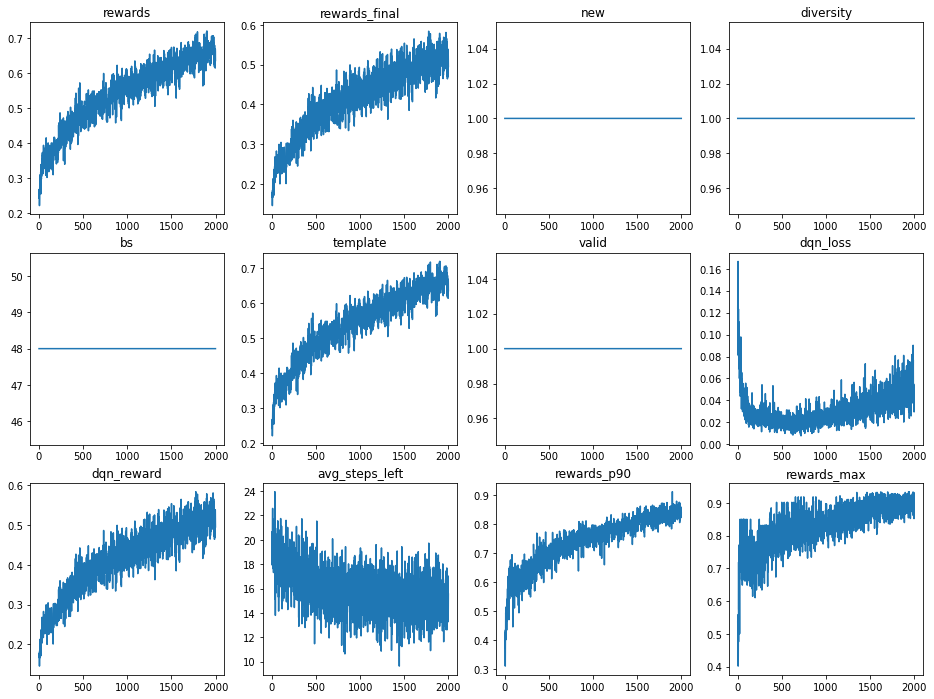

In [ ]:
env.log.plot_metrics()